# CATE Estimation Using Meta-Learners 

The dataset is loaded into a pandas DataFrame for manipulation and analysis.

In [3]:
# Load the dataset
pip install pandas
import pandas as pd
dataset = pd.read_csv('../data/dataset.csv')
print(dataset)

SyntaxError: invalid syntax (Temp/ipykernel_3540/3924149900.py, line 2)

Columns are renamed to more descriptive names for clarity.

In [49]:
data = dataset.rename(columns={
        'Y': 'StudentAchievementScore',
        'Z': 'GrowthMindsetIntervention',
        'S3': 'FutureSuccessExpectations',
        'C1': 'StudentRaceEthnicity',
        'C2': 'StudentGender',
        'C3': 'FirstGenCollegeStatus',
        'XC': 'SchoolUrbanicity',
        'X1': 'PreInterventionFixedMindset',
        'X2': 'SchoolAchievementLevel',
        'X3': 'SchoolMinorityComposition',
        'X4': 'PovertyConcentration',
        'X5': 'TotalStudentPopulation'
    })
print(data)

       schoolid  GrowthMindsetIntervention  StudentAchievementScore  \
0            76                          1                 0.081602   
1            76                          1                -0.385869   
2            76                          1                 0.398184   
3            76                          1                -0.175037   
4            76                          1                 0.884583   
...         ...                        ...                      ...   
10386         1                          0                 0.423366   
10387         1                          0                -0.197092   
10388         1                          0                 0.141698   
10389         1                          0                -0.351565   
10390         1                          0                 0.211240   

       FutureSuccessExpectations  StudentRaceEthnicity  StudentGender  \
0                              6                     4              2   
1

The dataset is split into treated and control groups based on the 'GrowthMindsetIntervention' column.

## S-Learner

The S-Learner is a straightforward method for estimating Conditional Average Treatment Effects (CATE) in observational studies. It combines the treatment indicator with covariates in a single model to predict outcomes. This simplicity can be advantageous but may not capture complex treatment interactions as effectively as other methods.
### S-Learner Algorithm Steps:
1. Combine Treatment and covariates:
    Construct a single dataset that includes both treatment indicator T and the covariates X.
2. Fit a Single Model:
    Fit a single predictive model to estimate the outcome Y using the combined dataset[X,T]
    Let Y^(X,T) be the predicted outcome from this model.
3. Predict counterfactuals:
    Predict the outcomes by setting the treatment indicator T to 1 and 0 respectively.
    For treated individuals: Y^(X) = Y^(X,T=1)
    For control individuals: Y^(X) = Y^(X,T=0)
4. Estimate Treatment Effects
    Compute the treatment effect for each individual as the difference between the two predicted outcomes: τ(X) = Y^1(X) - Y^0(X).


## S-Learner Model Training

In [4]:
# S-learner model RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
# Split the data into treatment and control groups
treated_data = data[data['GrowthMindsetIntervention'] == 1]
control_data = data[data['GrowthMindsetIntervention'] == 0]
print(treated_data)
print(control_data)

      schoolid  GrowthMindsetIntervention  StudentAchievementScore  \
0           76                          1                 0.081602   
1           76                          1                -0.385869   
2           76                          1                 0.398184   
3           76                          1                -0.175037   
4           76                          1                 0.884583   
...        ...                        ...                      ...   
3379         1                          1                -0.182348   
3380         1                          1                -0.183764   
3381         1                          1                -0.493196   
3382         1                          1                -1.108511   
3383         1                          1                -0.645656   

      FutureSuccessExpectations  StudentRaceEthnicity  StudentGender  \
0                             6                     4              2   
1              

The treatment column, outcome column, and covariate columns are defined. A feature matrix 
X is created by combining the covariates and the treatment column. The outcome vector 
Y is the 'StudentAchievementScore' column.

In [5]:
# Define columns
treatment_col = 'GrowthMindsetIntervention'
outcome_col = 'StudentAchievementScore'
covariate_cols = [
    'FutureSuccessExpectations', 'StudentRaceEthnicity', 'StudentGender',
    'FirstGenCollegeStatus', 'SchoolUrbanicity', 'PreInterventionFixedMindset',
    'SchoolAchievementLevel', 'SchoolMinorityComposition', 'PovertyConcentration',
    'TotalStudentPopulation'
    ]

In [6]:
# Create the covariates matrix and the outcome vector
X = pd.concat([data[covariate_cols], data[[treatment_col]]], axis=1)
Y = data[outcome_col]

A RandomForestRegressor model is trained using the combined data of covariates and treatment indicator to predict the outcome.

In [7]:
# Train a model on the combined data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, Y)

RandomForestRegressor(random_state=42)

Predictions for outcomes are made under both control (setting treatment to 0) and treatment (setting treatment to 1) conditions. The difference between these predictions gives the estimated CATE for each individual.

In [8]:
#pd.DataFrame with columns 'pred_0' and 'pred_1' for control and treatment predictions
X_control = X.copy()
X_control[treatment_col] = 0
pred_0 = model.predict(X_control)

X_treatment = X.copy()
X_treatment[treatment_col] = 1
pred_1 = model.predict(X_treatment)
print(pred_1)
print(pred_0)

[ 0.29827264 -0.48184832  0.17181445 ... -0.50513365 -0.39834549
 -0.52406924]
[-0.2583854  -0.3706101   0.16415784 ... -0.08301945 -0.43732902
  0.01875603]


In [9]:
Predictions = pred_1-pred_0

The predictions are filtered to focus on urban students (where 'SchoolUrbanicity' is 'Urban'). The average (CATE) for urban students is calculated and printed.

In [10]:
# Filter the for urban students
Urban_students_predictions = Predictions[data['SchoolUrbanicity'] == 4]

# Calculate and print the average CATE for urban students
CATE_Urban_S_LEARNER = Urban_students_predictions.mean()
print("Average CATE for Urban Students:", CATE_Urban_S_LEARNER)

Average CATE for Urban Students: 0.282949674320265


In [11]:
print(f"""This means that for the students from urban schools,
the achievement score was improved by {CATE_Urban_S_LEARNER:.2f} points
due to the Growth Mindset Intervention.""")

This means that for the students from urban schools,
the achievement score was improved by 0.28 points
due to the Growth Mindset Intervention.


# # T-Learner

The T-Learner is a common method for estimating Conditional Average Treatment Effects (CATE) in observational studies. It fits separate models for the treated and control groups, predicting outcomes based on covariates. This separation can effectively capture different treatment effects but requires sufficient data for both groups.
### T-Learner Algorithm steps:
1. Fit Separate Models:
    Fit two separate models: one for treated group (T=1) and one for the control group ( T=0)
    Let Y^1(X) and Y^(0) be the predicted outcomes from those models.
2. Predict Counterfactuals:
    For each individual, predict the outcomes using the respective models.
    For treated individuals: Y^0(X).
    For control individuals: Y^1(X).
3. Estimate Treatment Effects:
    Computer the treatment effect for each individual as the difference between the two predicted outcomes: τ(X) =Y^1(X)-Y^0(X)

## T-learner Model Training

Two models are trained: one on the treated group (using RandomForestRegressor) and one on the control group (using GradientBoostingRegressor).

In [12]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Feature matrices and outcome vectors
X_treated = treated_data[covariate_cols]
Y_treated = treated_data[outcome_col]
X_control = control_data[covariate_cols]
Y_control = control_data[outcome_col]

In [13]:
# Train the T-learner models
model_treated = RandomForestRegressor(n_estimators=100, random_state=42)
model_control = GradientBoostingRegressor(n_estimators=100, random_state=42)

In [14]:
model_treated.fit(X_treated, Y_treated)
model_control.fit(X_control, Y_control)

GradientBoostingRegressor(random_state=42)

Predictions for outcomes are made for all individuals using both models. The difference between these predictions gives the estimated CATE for each individual.

In [15]:
# Predict outcomes for all individuals under both treatment and control
X_all = data[covariate_cols]
pred_treated = model_treated.predict(X_all)
pred_control = model_control.predict(X_all)

In [16]:
predictions = pred_treated - pred_control


The CATE predictions are filtered to focus on urban students. The average CATE for urban students is calculated and printed.

In [17]:
# Filter CATE for urban students
urban_students = data['SchoolUrbanicity'] = 4
urban_students_predictions = predictions[urban_students]

In [18]:
# Calculate and print the average CATE for urban students
CATE_urban_T_LEARNER = urban_students_predictions.mean()
print(f"Average CATE for Urban Students: {CATE_urban_T_LEARNER:.2f}")

Average CATE for Urban Students: 0.20


A bar plot is created to compare the average CATE for urban students between the S-learner and T-learner models.

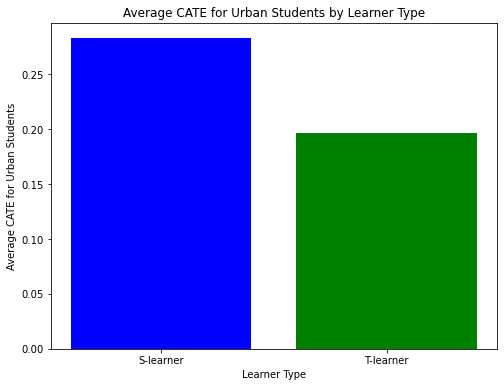

In [19]:
# To plot there predictions comparatively
import matplotlib.pyplot as plt
# Plot the average CATE for urban students
labels = ['S-learner', 'T-learner']
average_CATE_values = [CATE_Urban_S_LEARNER, CATE_urban_T_LEARNER]
plt.figure(figsize=(8, 6))
plt.bar(labels, average_CATE_values, color=['blue', 'green'])
plt.xlabel('Learner Type')
plt.ylabel('Average CATE for Urban Students')
plt.title('Average CATE for Urban Students by Learner Type')
plt.show()

##  Cross-Validation for Performance Evaluation

KFold cross-validation with 5 splits is set up to evaluate the models' performance. Lists are initialized to store the MSE results for both learners.

In [28]:
# Initialize KFold cross-validator
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
# Initialize lists to store results
s_learner_mse = []
t_learner_mse = []

In [30]:
for train_index, test_index in kf.split(data):
    print(f'Train indices: {train_index}, Test indices: {test_index}')

Train indices: [    1     2     4 ... 10387 10388 10390], Test indices: [    0     3     8 ... 10380 10384 10389]
Train indices: [    0     1     2 ... 10388 10389 10390], Test indices: [   12    17    26 ... 10370 10376 10385]
Train indices: [    0     1     3 ... 10388 10389 10390], Test indices: [    2    15    27 ... 10371 10381 10387]
Train indices: [    0     1     2 ... 10387 10388 10389], Test indices: [    6     7    18 ... 10383 10386 10390]
Train indices: [    0     2     3 ... 10387 10389 10390], Test indices: [    1     4     5 ... 10378 10379 10388]


For each fold, both S-learner and T-learner models are trained and predictions are made. The Mean Squared Error (MSE) between the predicted and actual outcomes is calculated and recorded for each model.

In [41]:
# Cross-validation loop
for train_index, test_index in kf.split(data):

    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]

    # S-learner model
    model_s_learner = RandomForestRegressor(n_estimators=100, random_state=42)
    X_train_s = pd.concat([train_data[covariate_cols], train_data[[treatment_col]]], axis=1)
    Y_train_s = train_data[outcome_col]
    X_test_s = pd.concat([test_data[covariate_cols], test_data[[treatment_col]]], axis=1)
    Y_test_s = test_data[outcome_col]

    model_s_learner.fit(X_train_s, Y_train_s)

    X_control_s = X_test_s.copy()
    X_control_s[treatment_col] = 0
    pred_0_s = model_s_learner.predict(X_control_s)

    X_treatment_s = X_test_s.copy()
    X_treatment_s[treatment_col] = 1
    pred_1_s = model_s_learner.predict(X_treatment_s)

    s_learner_predictions = pred_1_s - pred_0_s
    s_learner_mse.append(mean_squared_error(Y_test_s, s_learner_predictions))

    # T-learner model
    model_treated = RandomForestRegressor(n_estimators=100, random_state=42)
    model_control = GradientBoostingRegressor(n_estimators=100, random_state=42)

    X_treated_train = train_data[train_data[treatment_col] == 1][covariate_cols]
    Y_treated_train = train_data[train_data[treatment_col] == 1][outcome_col]
    X_control_train = train_data[train_data[treatment_col] == 0][covariate_cols]
    Y_control_train = train_data[train_data[treatment_col] == 0][outcome_col]

    model_treated.fit(X_treated_train, Y_treated_train)
    model_control.fit(X_control_train, Y_control_train)

    X_test = test_data[covariate_cols]
    pred_treated = model_treated.predict(X_test)
    pred_control = model_control.predict(X_test)

    t_learner_predictions = pred_treated - pred_control
    t_learner_mse.append(mean_squared_error(Y_test_s, t_learner_predictions))

In [42]:
print(s_learner_mse)
print(t_learner_mse)

[0.6665206610517551, 0.6450881696442995, 0.6828435707220557, 0.6072063139960513, 0.6741074188544497, 0.6665206610517551, 0.6450881696442995, 0.6828435707220557, 0.6072063139960513, 0.6741074188544497, 0.6665206610517551, 0.6450881696442995, 0.6828435707220557, 0.6072063139960513, 0.6741074188544497]
[0.6021710123185599, 0.5748144051244656, 0.621912210991378, 0.540066143898449, 0.5987781912288774, 0.5621205909945061, 0.5116276671683634, 0.5685250043132689, 0.4988681695965773, 0.5434686156863544, 0.6021710123185599, 0.5748144051244656, 0.621912210991378, 0.540066143898449, 0.5987781912288774]


In [43]:
import numpy as np
# Calculate the average MSE for each learner
average_s_learner_mse = np.mean(s_learner_mse)
average_t_learner_mse = np.mean(t_learner_mse)
print(f"Average MSE for S-learner: {average_s_learner_mse:.4f}")
print(f"Average MSE for T-learner: {average_t_learner_mse:.4f}")

Average MSE for S-learner: 0.6552
Average MSE for T-learner: 0.5707


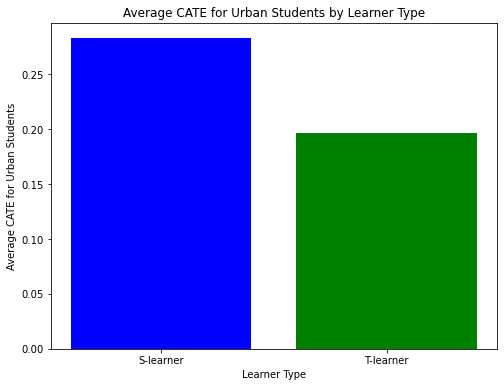

In [44]:
# Plot the average CATE for urban students
labels = ['S-learner', 'T-learner']
average_CATE_values = [CATE_Urban_S_LEARNER, CATE_urban_T_LEARNER]
plt.figure(figsize=(8, 6))
plt.bar(labels, average_CATE_values, color=['blue', 'green'])
plt.xlabel('Learner Type')
plt.ylabel('Average CATE for Urban Students')
plt.title('Average CATE for Urban Students by Learner Type')
plt.show()


# X-Learner

The X-Learner is an advanced method for estimating Conditional Average Treatment Effects (CATE) in observational studies. It combines the strengths of T-Learners and S-Learners to improve robustness and accuracy, especially when the treatment and control groups are imbalanced.

### X-Learner Algorithm Steps:
1. Fit Separate Models:
    Fit two separate models: one for the treated group (𝑇=1) and one for the control group (𝑇=0).
    Let 𝑌^1(𝑋) and 𝑌^0(X) be the predicted outcomes from these models.
2. Impute Treatment Effects:
    For each treated individual, impute the counterfactual outcome if they had not been treated using the control group model:𝑌^0(X).
    For each control individual, impute the counterfactual outcome if they had been treated using the treated group model: 𝑌^1(X).
3. Estimate Treatment Effects:
    For the treated group, compute the treatment effect as 𝐷1=Y1-Y^0(X)
    For the control group, compute the treatment effect as D0=Y^1(X) -Y0
4. Fit Secondary Models:
    Fit two new models to predict D1 and D0 using the covariates X.
5. Combine Predictions:
    Combine the predictions from the secondary models, weighting them by the propensity scores or using some other method to average the treatment effect predictions for the entire population.

In [57]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Assuming data is a pandas DataFrame and the necessary columns are defined
kf = KFold(n_splits=5, shuffle=True, random_state=42)

x_learner_mse = []

for train_index, test_index in kf.split(data):
    train_data = data.iloc[train_index]
    test_data = data.iloc[test_index]

    # Step 1: Fit separate models for treated and control groups
    model_treated = RandomForestRegressor(n_estimators=100, random_state=42)
    model_control = RandomForestRegressor(n_estimators=100, random_state=42)

    X_treated_train = train_data[train_data[treatment_col] == 1][covariate_cols]
    Y_treated_train = train_data[train_data[treatment_col] == 1][outcome_col]
    X_control_train = train_data[train_data[treatment_col] == 0][covariate_cols]
    Y_control_train = train_data[train_data[treatment_col] == 0][outcome_col]

    model_treated.fit(X_treated_train, Y_treated_train)
    model_control.fit(X_control_train, Y_control_train)

    # Step 2: Impute treatment effects
    X_control_test = test_data[test_data[treatment_col] == 0][covariate_cols]
    Y_control_test = test_data[test_data[treatment_col] == 0][outcome_col]
    X_treated_test = test_data[test_data[treatment_col] == 1][covariate_cols]
    Y_treated_test = test_data[test_data[treatment_col] == 1][outcome_col]

    imputed_te_control = model_treated.predict(X_control_test) - Y_control_test
    imputed_te_treated = Y_treated_test - model_control.predict(X_treated_test)

    # Step 3: Train imputation models
    model_impute_control = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model_impute_treated = GradientBoostingRegressor(n_estimators=100, random_state=42)

    # Note: imputed_te_control and imputed_te_treated need to be the same length as X_control_train and X_treated_train respectively
    model_impute_control.fit(X_control_test, imputed_te_control)
    model_impute_treated.fit(X_treated_test, imputed_te_treated)

    # Step 4: Predict treatment effects for the test set
    X_test = test_data[covariate_cols]
    pred_te_control = model_impute_control.predict(X_test)
    pred_te_treated = model_impute_treated.predict(X_test)

    # Combine predictions
    treatment_proba = test_data[treatment_col].mean()
    x_learner_predictions = treatment_proba * pred_te_treated + (1 - treatment_proba) * pred_te_control
    
    
    # Calculate and store the MSE
    Y_test = test_data[outcome_col]
    x_learner_mse.append(mean_squared_error(Y_test, x_learner_predictions))

print("X-Learner MSE:", np.mean(x_learner_mse))

X-Learner MSE: 0.557344926776508


## R-Learner

The R-Learner is another meta-learning approach for estimating the Conditional Average Treatment Effect (CATE) that leverages the residuals from outcome and treatment models.

### R-Learner Algorithm Steps:
1. Estimate Propensity Scores
    Estimate the propensity scores, which are the probabilities of receiving treatment, using a logistic regression model. This helps in balancing the covariates between the treated and control groups.
        Fit a logistic regression model to the covariates 𝑋 to predict the treatment indicator 𝑇.
        Obtain the propensity scores 𝑒^(𝑋), which are the predicted probabilities of receiving the treatment.
2.  Fit Outcome Models and Compute Residuals
    Fit an outcome model to predict the outcomes for both treated and control groups. Compute the residuals by subtracting the predicted outcomes from the actual outcomes. These residuals represent the part of the outcome that is not explained by the covariates.
        Fit an outcome model to predict the outcome 𝑌 using the covariates 𝑋.
        Predict the outcomes 𝑌^(𝑋)using the fitted model.
        Compute the residuals 𝜖 by subtracting the predicted outcomes from the actual outcomes: ϵ=Y− Y^(X).
3. Calculate the Residualized Treatment Effect
   Calculate the residualized treatment effect using the residuals and the propensity scores. This involves computing the difference between the treatment indicator and the propensity scores, and then normalizing the residuals by this difference.
        Compute the residualized treatment indicator 𝑊 as the difference between the treatment indicator and the propensity scores: W=T− e^(X).
        Calculate the residualized treatment effect 𝑍 by normalizing the residuals by 𝑊:Z=ϵ/W.
4. Fit the Residualized Treatment Effect Model
   Fit a model to predict the residualized treatment effect using the covariates. This model helps in estimating how the treatment effect varies with the covariates.
        Fit a model to the residualized treatment effect 𝑍 using the covariates 𝑋. This model aims to predict 𝑍 based on 𝑋.
    
5. Estimate the Conditional Average Treatment Effect (CATE)
   Use the fitted model to estimate the CATE for the entire population. The CATE estimates represent the expected difference in outcomes between treated and control groups, conditional on the covariates.
        Use the fitted residualized treatment effect model to predict the CATE for the entire population.
        The CATE estimates τ(X) represent the expected difference in outcomes between the treated and control groups, conditional on the covariates 𝑋.